# Лабораторная работа 4. Подбор гиперпараметров. Калибровка. Работа с текстовыми данными. Библиотека Vowpal Wabbit.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

Работы, в которых удалены формулировки заданий, проверять сложнее, поэтому за решения без формулировок заданий мы будем снижать баллы в два раза.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_04.ipynb.

## О работе

Данная лабораторная работа знакомит с несколькими полезными техниками, применимыми в машинном обучении. Вы узнаете какие есть стратегии при подборе гиперпараметров; в каких случаях может понадобиться калибровка классификатора; в чем заключается сложность при работе с текстовыми данными на практике. 

### Перед отправкой работы убедитесь в том что:
 - В ноутбуке присутствуют формулировки заданий.
 - На вопросы даны развернутые ответы.
 - У графиков подписаны оси, легенда и заголовок.
 
За невыполнение указанных выше пунктов при проверке снимаются баллы.

## Оценивание качества классификации

Перед тем, как приступить к выполнению заданий, рассмотрим метрики классификации, которые нам пригодятся в дальнейшем.

### Accuracy, Precision, Recall

- Accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (Мы не рекомендуем переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- Precision (точность): $$Precision = \frac{TP}{TP + FP}$$
- Recall (полнота): $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Обратите внимание, что точность и полнота вычисляются относительно фиксированного класса. В sklearn есть удобная функция [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), позволяющая сразу вычислять эти метрики для всех классов. 

Точность и полнота хороши тем, что могут быть использованы в случае несбалансированных данных, однако сразу же две метрики оптимизировать не удобно.

### Precision-Recall кривая

Зачастую классификатор может возвращать не ответ *0* или *1*, а некоторую меру принадлежности заданному классу $b(x)$, которая сравнивается с фиксированным порогом *t*, и на самом деле классификатор имеет вид $a(x) = [b(x) > t]$. Таким образом, при оценивании качества работы классификатора можно использовать его ответ $b(x)$ и подбирать порог *t* исходя из некоторых условий. Кроме того, выбор порога влияет на качество классификации:
 - чем больше $t$, тем выше точность, но ниже полнота,
 - чем меньше $t$, тем выше полнота, но ниже точность.

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого строят следующий график: переберем все возможные пороги $t$, откладывая по оси OX полноту получившегося классификатора, а по оси OY — точность. Таким образом можно получить хорошую визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Как следствие, можно измерять площади под указанными кривыми — *Precision-Recall AUC* и *AUC-ROC* соответственно.

### LogLoss

В бинарном случае эта метрика записывается как $$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

В отличии от *AUC-ROC*, для этой метрики необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу, а не "степени принадлежности классу 1" в неопределенной шкале. Приведем пример. Вероятностная шкала может быть нужна, если вы хотите оценить количество денег, которые в среднем принесёт пользователь, кликнув на баннер. Для этого необходимо умножить количество денег, которые вы получаете за клик на баннер, на вероятность клика пользователя, которую предсказывает модель.

## Подбор гиперпараметров. Случайный поиск по сетке

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, так как для каждого фиксированного набора гиперпараметров происходит новое обучение алгоритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственным возможным. Рассмотрим более подробно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге алгоритм будет обучен 80 раз, что уже немало. А если, например, рассмотреть случайный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число обучений алгоритма, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют случайный поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого выбираются его значения. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимальные значения быстрее. 

Сравнение обычного поиска по сетке со случайным можно проиллюстрировать следующим образом:

![](http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg)

Более детально о случайном поиске по сетке можно прочесть по следующим ссылкам:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

При выполнении этой части задания будем использовать [набор данных](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) с информацией о клиентах банка и их платежах.

![](https://s2.postimg.org/jm4gryimx/dataset-cover.jpg)

Загрузите данные из файла *credit_card_clients.tsv* и разбейте на обучающее и тестовое множество в отношении 4 к 1.

In [2]:
import pandas as pd
import numpy as np

x = pd.read_table('credit_card_clients.tsv')
train = x[x['ID'] <= x.shape[0]*4/5].values
test = x[x['ID'] > x.shape[0]*4/5].values

**(2 балла) Задание 1.**

Целью данного задания является сравнение описанных выше подходов подбора гиперпараметров на практике. А именно, посмотрим как ведет себя обычный и случайный поиск по сетке при одинаковом числе операций (бюджете). Попробуем найти оптимальные гиперпараметры для SVM с линейным ядром. В данном случае нам будет интересны найти значения у двух параметров: *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)), для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000. В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

 - Для обычного поиска по сетке ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)) сделайте 5 запусков поиска гиперпараметров с бюджетом 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайного) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество.
 
Данная часть лабораторной работы может работать значительное время. Поэтому рекомендуем обратить внимание на параметр *n_jobs* поиска по сетке (есть у обоих классов).

In [3]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC

budget = [4, 9, 16, 25, 36]
best_quality_rand = []
best_params_grid = []
best_quality_grid = []
best_params_rand = []
linear_svm = LinearSVC()
for i in range(5):
    c_param = np.logspace(-1, 2, i+2, endpoint = False)
    iter_param = np.logspace(3, 4, i+2, endpoint = False)
    dict_param = {'C': c_param, 'max_iter': iter_param}
    grid = GridSearchCV(linear_svm, dict_param, scoring = 'roc_auc', n_jobs=-1)
    rand = RandomizedSearchCV(linear_svm, dict_param, scoring = 'roc_auc', n_jobs=-1, n_iter = budget[i])
    rand.fit(train[:,1:24], train[:,24])
    grid.fit(train[:,1:24], train[:,24])
    best_quality_rand.append(rand.best_score_)
    best_quality_grid.append(grid.cv_results_['mean_test_score'].max())
    best_params_rand.append(rand.best_params_)
    best_params_grid.append(grid.best_params_)

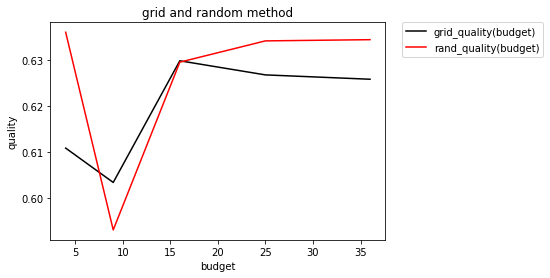

In [8]:
import matplotlib
import matplotlib.pylab as plt

plt.plot(budget, best_quality_grid, color = 'black', label = 'grid_quality(budget)')
plt.plot(budget, best_quality_rand, color = 'red', label = 'rand_quality(budget)')
plt.title('grid and random method')
plt.xlabel('budget')
plt.ylabel('quality')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**(1 балл) Задание 2.**

Что вы можете сказать о получившемся графике? Посмотрите на наилучшие гиперпараметры, которые у вас получились. Можно ли сказать, что какой-то из гиперпараметров больше влияет на результат? Можно ли сделать вывод, что случайный поиск проигрывает или же наоборот? Зависит ли ответ на предыдущий вопрос от размера бюджета и удачной инициализации?

In [10]:
print('Best params of rand search')
print(best_params_rand)
print('Best params of grid search')
print(best_params_grid)

Best params of rand search
[{'max_iter': 3162.2776601683795, 'C': 3.1622776601683795}, {'max_iter': 4641.5888336127773, 'C': 10.0}, {'max_iter': 5623.4132519034911, 'C': 3.1622776601683795}, {'max_iter': 1584.893192461114, 'C': 0.10000000000000001}, {'max_iter': 6812.9206905796082, 'C': 31.622776601683793}]
Best params of grid search
[{'max_iter': 1000.0, 'C': 0.10000000000000001}, {'max_iter': 2154.4346900318847, 'C': 10.0}, {'max_iter': 1000.0, 'C': 0.10000000000000001}, {'max_iter': 1000.0, 'C': 0.3981071705534972}, {'max_iter': 6812.9206905796082, 'C': 0.31622776601683794}]


**График показывает, что случайный метод показал лучший результат, один раз значение метрики качества резко просело по сравнению с остальными, но это могло не повезти, поэтому можно сделать вывод, что случайный метод выигрывает.  Можно заметить, что параметр max_iter меньше влияет на качество (есть даже пара наборов, где константа С одинакова, а mat_iter не сильно повлиял не улучшение качества, да и это логично, ведь метод может сойтись раньше, чем количество итераций доберётся да верхней границы. С возрастанием бюджета можно увидеть разницу в методах по качеству, хотя это вроде как уменьшает вероятность попадания в лучший вариант параметров.**

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. Как было сказано выше, в этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
Если считать что в общем случае первый подход не самый удачный выбор, рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое бы искажало возвращаемое значение в вероятность  — это и называется калибровкой. Есть несколько известных методов для этого:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны производиться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. Внутри библиотеки реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

**(2 балла) Задание 3.**
 
Рассмотрим SVM из предыдущего пункта. Примените оба описанных выше подхода для калибровки: Платта и изотоническую регрессию. Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 
В данном задании необходимо воспользоваться методом *decision_function*, который вернет значение отступа на объекте. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

**(1 балл) Задание 4.**
 - Посчитайте *logloss* на тестовой выборке для исходного и классификатора после калибровки.
 - Дает ли калибровка прирост качества?
 - Какой из способов калибровки в данном случае работает лучше?
 - Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат?
 - Почему калибровка практически не должна повлиять на *AUC-ROC*? 

## Работа с текстовыми данными

В остальной части задания мы будем работать с подмножеством датасета IMDB Movies Reviews из соревнования [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). 
![](http://i.imgur.com/QZgxFic.png)

Задача состоит в следующем: по отзыву на фильм необходимо понять является ли он положительным или отрицательным. Это один из примеров задачи анализа тональности текста ([sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)). Пример отзыва из выборки:
    
    This can be one of the most enjoyable movies ever if you don't take it seriously. It is a bit dated and the effects are lame, but it is so enjoyable. There are giant crabs that attack a girl. oh, and the crabs sing Japanese. It is amazingly bad. And the ending, which has been telegraphed throughout the entire film is hideously awesome. Predictable, but seeing the final fight will leave you rolling in your seat. Don't even give this film a chance and you will love it. Susan George is fun to watch and yes, she does appear naked. Her daughter isn't quite worth putting up with, but she does get attacked by giant crabs. They are the size of large cats. This is a 2, but I love it. As a movie, my God, but for entertainment, I give it a 7. Did I mention there are giant crabs?


Загрузите датасет из файла *feedback_data.tsv*.

In [237]:
reviews_table = pd.read_table('feedback_data.tsv')

Для оценивания качества в данной задаче мы будем использовать отложенную выборку. Разделите все данные на две части: 16000 объектов будут в обучающей выборке и 4000 объектов — в тестовой.

При разбиении выборки на две части, необходимо будет учесть следующие особенности разбиения:
 - Разбиение должно быть воспроизводимо.
 - Соотношение классов в каждой из частей должно сохраняться (например, при использовании функции *train_test_split* указать *stratify*).

In [98]:
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(reviews_table.review, reviews_table.sentiment, 
                                               stratify = reviews_table.sentiment, test_size=0.2, train_size = 0.8)
train_x = train_x.values
test_x = test_x.values
train_y = train_y.values
test_y = test_y.values

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.



Для начала попробуем самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Для данного подхода хорошей практикой является отфильтровывать стоп-слова.

Это представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много 0. Более подробно про такие матрицы можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

Примените *bag-of-words* кодирование данных. Мы рекомендуем здесь и в дальнейшем обучать преобразование на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные?

In [207]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer()
train_matrix = bag_of_words.fit_transform(train_x)
test_matrix = bag_of_words.transform(test_x)

In [113]:
print('Train matrix shape:')
print(train_matrix.shape)
print('Test matrix shape:')
print(test_matrix.shape)

Train matrix shape:
(16000, 62518)
Test matrix shape:
(4000, 62518)


**(0.5 балла) Задание 5.**



Какие недостатки для данной задачи вы видите у метрики Accuracy?


 **Если в выборке отношение положительных и отрицательных отзывов не близко к кдинице, метрика не дакт представления, как точно алгоритм классификации определяет конкретный тип отзывов (если много отрицательных отзывов, метрика будет неплохой, даже если бездумно классифицировать всё как отрицательный отзыв, что плохо)**.


 **Если нам очень-очень важно находить отзывы одного из типов, по значению метрики мы не поймём, как хорошо мы это делаем.**

Обучите логистическую регрессию и случайный лес с 500 деревьев на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик: *Accuracy*, *Precision*, *Recall*. Кроме этого, сравните время обучения алгоритмов. Есть ли существенная разница в качестве предсказаний данных алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?

In [102]:
from  sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(500, n_jobs = -1)
random_forest.fit(train_matrix, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [103]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(n_jobs = -1)
log_reg.fit(train_matrix, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
y_random_forest = random_forest.predict(test_matrix)
y_log_reg = log_reg.predict(test_matrix)


In [109]:
from sklearn.metrics import accuracy_score

print('Accuracy for random forest:')
print(accuracy_score(test_y, y_random_forest))
print('Accuracy for logistic regression:')
print(accuracy_score(test_y, y_log_reg))

Accuracy for random forest:
0.79225
Accuracy for logistic regression:
0.87775


In [110]:
from sklearn.metrics import recall_score

print('Recall for random forest:')
print(recall_score(test_y, y_random_forest))
print('Recall for logistic regression:')
print(recall_score(test_y, y_log_reg))

Recall for random forest:
0.481333333333
Recall for logistic regression:
0.835333333333


In [111]:
from sklearn.metrics import precision_score

print('Precision for random forest:')
print(precision_score(test_y, y_random_forest))
print('Precision for logistic regression:')
print(precision_score(test_y, y_log_reg))

Precision for random forest:
0.931612903226
Precision for logistic regression:
0.838127090301


**Обучение метода логистической регрессии прошло куда быстрее, чем случайного леса, при этом значение 2 метрик получилось лучше, и для  recall получилсь очень большая разница. Чтобы выбрать более предпочтительный метод нужно понимать, как алгоритмы обрабатывают закодированный текст при обучении, до даже мне понятно, что они оба не шибко логично анализируют текст, потому что кодировка такая, поэтому будем смотреть результат нашего эксперимента, верить в него и брать логистическую регрессию.**

Посмотрев на указанные метрики, можно понять, что классификаторы неплохо справляются с нулевым классом и похуже — с первым. Скорее всего, это результат того, что положительных отзывов почти вдвое меньше чем отрицательных. В дальнейшем нас будет интересовать как классификатор справляется именно с положительными отзывами (то есть с первым классом).

**(1.5 балла) Задание 6.**

Постройте *Precision-Recall* и *ROC* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

In [118]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib
import matplotlib.pylab as plt

Random forest auc score
0.730066666667
Logistic regression auc score
0.869266666667


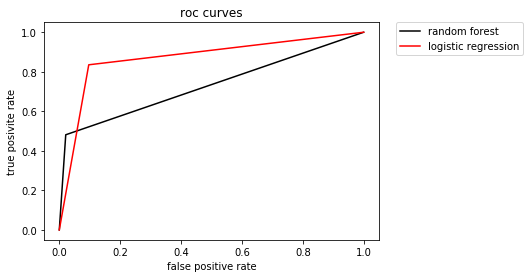

In [130]:
fpr, tpr, thr = roc_curve(test_y, y_random_forest)
print('Random forest auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'black', label = 'random forest')
fpr, tpr, thr = roc_curve(test_y, y_log_reg)
print('Logistic regression auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'red', label = 'logistic regression')
plt.title('roc curves')
plt.xlabel('false positive rate')
plt.ylabel('true posivite rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [128]:
rand_proba = random_forest.predict_proba(test_matrix)
log_proba = log_reg.predict_proba(test_matrix)

[ 0.6    0.372  0.678 ...,  0.476  0.204  0.686]


array([ 0.4  ,  0.628,  0.322, ...,  0.524,  0.796,  0.314])

Random forest precision-recall score
0.222455345586
Logistic regression precision-recall score
0.220616142701


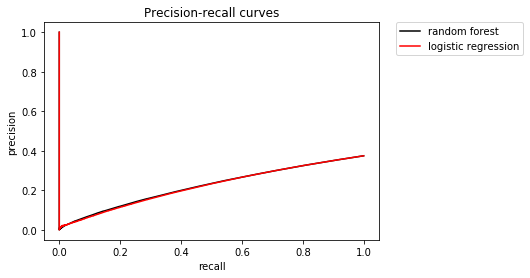

In [148]:
prec, recall, thr = precision_recall_curve(test_y, rand_proba[:,0])
print('Random forest precision-recall score')
print(auc(recall, prec))
plt.plot(recall, prec, color = 'black', label = 'random forest')
prec, recall, thr = precision_recall_curve(test_y, log_proba[:,0])
print('Logistic regression precision-recall score')
print(auc(recall, prec))
plt.plot(recall, prec, color = 'red', label = 'logistic regression')
plt.title('Precision-recall curves')
plt.ylabel('precision')
plt.xlabel('recall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Если мы хотим, чтобы классификатор находил, например, не менее 80% положительных отзывов, то необходимо потребовать, чтобы полнота была не менее 0.8. 

**(1 балл) Задание 7.**

Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.8.

In [164]:
prec, recall, thr = precision_recall_curve(test_y, rand_proba[:,0])
max_score = 0
for i in range(recall.shape[0]):
    if (recall[i] >= 0.8 and recall[i+1] < 0.8):
        max_score = thr[i]
print('Max score random forest')
print(max_score)

prec, recall, thr = precision_recall_curve(test_y, log_proba[:,0])
max_score = 0
for i in range(recall.shape[0]):
    if (recall[i] >= 0.8 and recall[i+1] < 0.8):
        max_score = thr[i]
print('Max score logistic regression')
print(max_score)

Max score random forest
0.406
Max score logistic regression
0.000494156313952


В дальнейшем для экспериментов будем использовать логистическую регрессию. Можно заметить, что по некоторым причинам мы не находили оптимальные параметры для алгоритмов, а работали с параметрами по умолчанию. Чтобы исправить этот недостаток, в дальнейшем используйте понравившийся вам метод поиска гиперпараметров (из описанных выше) для нахождения наилучшего значения параметра *C* у логистической регрессии.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным из-за большой матрицы объект-признак. Это ведет как к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума. 

## Отбор признаков и уменьшение размерности

### По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте (не считая стоп-слов вроде "a", "the", "it", ...). Кажется, что вхождение наиболее частых слов в отзыве, например *good*, *bad* и т.д. являются вполне неплохими показателями.

### С помощью машинного обучения
Другой подход — воспользоваться имеющимся машинным обучением — обученным на всех признаках случайным лесом. Одним из свойств случайного леса является оценка важности признаков. Таким образом, можно выбрать топ слов, важных как признаки для задачи классификации. 

### Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Из-за коллизий можно обработать не встречавшихся ранее слов. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Можно заметить, что два последних подхода можно применять не обязательно к текстовым данным.

**(2 балла) Задание 8.**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ наиболее "важных" слов с помощью случайного леса
 - топ самых частотных слов
 - с помощью хэширования
 
Для последних двух выборок не забывайте фильтровать стоп-слова, для этого можно использовать параметр stop_words='english' у классов CountVectorizer, HashingVectorizer.

На четырех выборках (*bag-of-words* и трех новых) постройте *roc*-кривые, вычислив площадь под ними. Что вы можете сказать о качестве этих подходов к сокращению размерности?

Выведите топ-20 самых важных слов от случайного леса и сравните их с топ-20 наиболее частотных. Много ли общих слов?

In [174]:
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer

count_vectorizer = CountVectorizer(max_features = 15000, stop_words = 'english')
count_features = count_vectorizer.fit_transform(train_x)
count_test = count_vectorizer.transform(test_x)

In [181]:
hash_vectorizer = HashingVectorizer(n_features = 15000, stop_words = 'english')
hash_vectorizer.fit(train_x)
hash_features = hash_vectorizer.transform(train_x)
hash_test = hash_vectorizer.transform(test_x)

In [208]:
bound = sorted(random_forest.feature_importances_)[train_matrix.shape[1] - 15000]
index = np.where(random_forest.feature_importances_ >= bound)

In [209]:
forest_features = train_matrix.transpose()[index].transpose()
forest_test = test_matrix.transpose()[index].transpose()

**Подбор параметра:**

In [220]:
log_reg_obj = LogisticRegression()
c_param = np.logspace(0, 1, 4, endpoint = False)
dict_param = {'C': c_param}
rand = RandomizedSearchCV(linear_svm, dict_param, scoring = 'roc_auc', n_jobs=-1, n_iter = 4)
rand.fit(train_matrix, train_y)
params = rand.best_params_

**Логистическая регрессия с подобранным параметром:**

In [224]:
log_reg_hash = LogisticRegression(n_jobs = -1, C = params['C'])
log_reg_hash.fit(hash_features, train_y)

log_reg_count = LogisticRegression(n_jobs = -1, C = params['C'])
log_reg_count.fit(count_features, train_y)

log_reg_forest = LogisticRegression(n_jobs = -1, C = params['C'])
log_reg_forest.fit(forest_features, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [226]:
log_reg_forest_old = LogisticRegression(n_jobs = -1, C = params['C'])
log_reg_forest_old.fit(train_matrix, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [228]:
y_hash = log_reg_hash.predict(hash_test)
y_count = log_reg_count.predict(count_test)
y_forest = log_reg_forest.predict(forest_test)
y_forest_old = log_reg_forest_old.predict(test_matrix)

Hash vectorizing auc score
0.848
Count vectorizing auc score
0.8606
Best forest features auc score
0.868133333333
All forest features auc score
0.869266666667


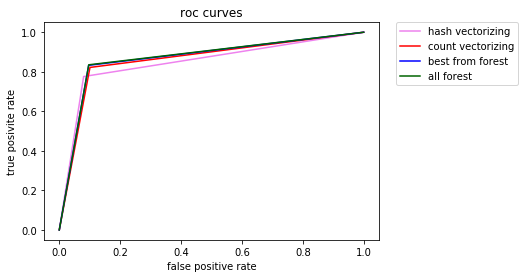

In [231]:
fpr, tpr, thr = roc_curve(test_y, y_hash)
print('Hash vectorizing auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'violet', label = 'hash vectorizing')

fpr, tpr, thr = roc_curve(test_y, y_count)
print('Count vectorizing auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'red', label = 'count vectorizing')

fpr, tpr, thr = roc_curve(test_y, y_forest)
print('Best forest features auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'blue', label = 'best from forest')

fpr, tpr, thr = roc_curve(test_y, y_forest_old)
print('All forest features auc score')
print(auc(fpr, tpr))
plt.plot(fpr, tpr, color = 'darkgreen', label = 'all forest')

plt.title('roc curves')
plt.xlabel('false positive rate')
plt.ylabel('true posivite rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [233]:
bound = sorted(random_forest.feature_importances_)[train_matrix.shape[1] - 20]
index = np.where(random_forest.feature_importances_ >= bound)

In [236]:
print('Most valuable word numbers in random forest:')
print(index)

Most valuable word numbers in random forest:
(array([ 2708,  4388,  4578,  5853, 19200, 23948, 27652, 29037, 30036,
       33043, 36822, 38200, 38922, 55303, 55457, 55642, 56108, 60369,
       61408, 61583]),)


Таким образом, удалось сократить размерность более чем в три раза без сильной потери в качестве. Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве. 

### PCA

Одним из способов сокращения размерности является метод главных компонент ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**(1 балл) Задание 9.**

Попробуйте сократить размерность до 2000 двумя способами:
 - наилучшим из трех предыдущих
 - для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?

Для первых трех компонент преобразования найдите топ-30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

**Будем брать метод, берущий самые важные слова из случайного леса, теперь этих слов будет 2000.**

In [ ]:
bound = sorted(random_forest.feature_importances_)[train_matrix.shape[1] - 2000]
index = np.where(random_forest.feature_importances_ >= bound)
forest_features = train_matrix.transpose()[index].transpose()
forest_test = test_matrix.transpose()[index].transpose()

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось слово (например, чтобы избавиться от очень редких слов). В этом случае может помочь [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода — брать абсолютные частоты. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно сделать логарифмирование, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.


## Библиотека Vowpal Wabbit

Еще одним подходом для работы с текстовым данными является использование библиотеки [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki).

VW представляет из себя хорошую реализация стохастического градиентного спуска для линейных моделей. К преимуществам и особенностям данной библиотеки можно отнести:
 - Считывание с диска происходит батчами, VW делает каждый следующий шаг градиентного спуска только по батчу, поэтому нет необходимости хранить всю выборку в памяти, из-за чего его удобно применять для больших выборок при ограниченных ресурсах.
 - Из коробки работают: нормализация признаков, взвешивание объектов, адаптивный градиентный шаг, матричные разложения, тематическое моделирование, активное обучение, обучение с подкреплением.
 - Реализация VW содержит различные методы оптимизации: сопряженные градиенты, квазиньютоновские методы (L-BFGS).
 - VW может быть запущен на кластере.

Перед началом работы с vw полезно будет ознакомиться с информацией по ссылкам:
 - [Туториал по VW](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)
 - [Описание формата входных данных](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format)
 - [Описание параметров командной строки](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments)

Приведите обучающую и тестовую выборки к формату пригодному для обучения модели с помощью vw: в качестве признаков используйте тексты отзывов как есть. Например:

**(2 балла) Задание 10.**

Обучите Vopwal Wabbit на полученной выборке. В качестве функции потерь (параметр [loss_function](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)) попробуйте использовать:
  - логистическую (logistic)
  - кусочно-линейную (hinge)

Постройте *Precision-Recall* и *ROC* кривые для каждой из получившихся моделей. Сравните время обучения и получившееся качество со временем обучения и качеством предыдущих моделей.

## Выводы

**(0.5 балла) Задание 11.**

В первой части лабораторной работы мы рассмотрели 2 способа подбора гиперпараметров и калибровки алгоритмов машинного обучения. Ответьте на следующие вопросы:

- В каких случаях случайный поиск гиперпараметра имеет преимущество, в сравнении с перебором по сетке? Приведите пример такого случая.
- Для какого типа задач машинного обучения имеет смысл использовать калибровку предсказаний? Приведите пример такой задачи.

Приведенные примеры не должны совпадать с упомянутыми ранее в работе.

**(0.5 балла) Задание 12.**

В второй части лабораторной работы мы рассмотрели несколько методов работы с текстовыми данными. Ответьте на следующие вопросы:

- Какие есть достоинства у рассмотренных методов представления текстовых данных? Поясните свой ответ для каждого рассмотренного метода.
- Каким общим недостатком обладают данные методы?
- Какие модели машинного обучения больше подходят для работы с текстовыми данными на практике и почему? В чём их преимущество перед другими алгоритмами?

**Во всех реализованных мной методах работы с текстами главый недостаток -- большое количество признаков,что влияет на время выполнения обучения по этим признакам, а также проблемы с тем, чтобы определить более важные призначи, чтобы отбросить менне важные и не потерять в качестве. Сами признаки в большинстве своём универсальны, что не очень хорошо, если дан специфический текст, где понадобились бы эта самые специфические признаки. **